# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Tuesday, 3/24/2015


### Lesson 2: Working with Graph Libraries

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/XohP/logo300.png) 

![](http://igraph.org/img/igraph3.svg)


## Background 
Cytoscape is an all-in-one package for network data integration, analysys, and visualization.  However, there are several powerful graph abnalysis tools designed for advanced users.  They usually have command-line interface and are not easy to use for interactive data visualization.  __By using cyREST, you can access the best of the two worlds!__

### Cytoscape vs Other Graph Libraries

#### Cytoscape

![](http://www.cytoscape.org/images/logo/cy3logoOrange.svg)

##### Pros
* Easy-to-use GUI
* All-in-one
* Advanced visualization features

##### Cons
* GUI operation...
    * Not easy to integrate it into automated workflows
* Scalability
    * Designed to run on workstations

#### Command-Line Graph Analysis Tools

![](http://igraph.org/img/igraph3.svg)

##### Pros
* Lots of graph analysis algorithms
* High performance
    * Not always true, but some of them use C/C++ modules for optimization

##### Cons
* Limited visualization features
* Hard to use for people with limited computing literacy

## Use Cytoscape as an external visualization engine
In this section, you will learn the following:

* Load network data sets to NetworkX graph object
* Calculate basic statistics of the graph
* Visualize it in Cytoscape

----

## Overview of Popular Graph Libraries

### NetworkX
One of the most popular graph analysis library in Python community.  It is easy to install, but a bit slower than the other two.

### igraph
Very popular library in R programmers, but also available for Python.  Lots of graph analysis functions and popular in social network analysis community.

### Graph-Tool
In most cases, this is the fastest graph analysis library.  Optimization is done by calling external [Boost C++ library](http://www.boost.org/doc/libs/1_57_0/libs/graph/doc/table_of_contents.html). 

In this container, all of these three are installed and ready to use!

In [14]:
import requests
import json
import networkx as nx
from IPython.display import Image

from py2cytoscape import util as cy 

from collections import OrderedDict
import numpy as np
from bokeh.charts import Bar
from bokeh.plotting import *

import matplotlib.pyplot as plt
%matplotlib inline

output_notebook()

import pandas as pd

PORT_NUMBER = 1234
IP = '10.0.1.6'
BASE = 'http://' + IP +  ':' + str(PORT_NUMBER) + '/v1/'
HEADERS = {'Content-Type': 'application/json'}

# Start from a clean slate!
requests.delete(BASE + 'session')

<Response [200]>

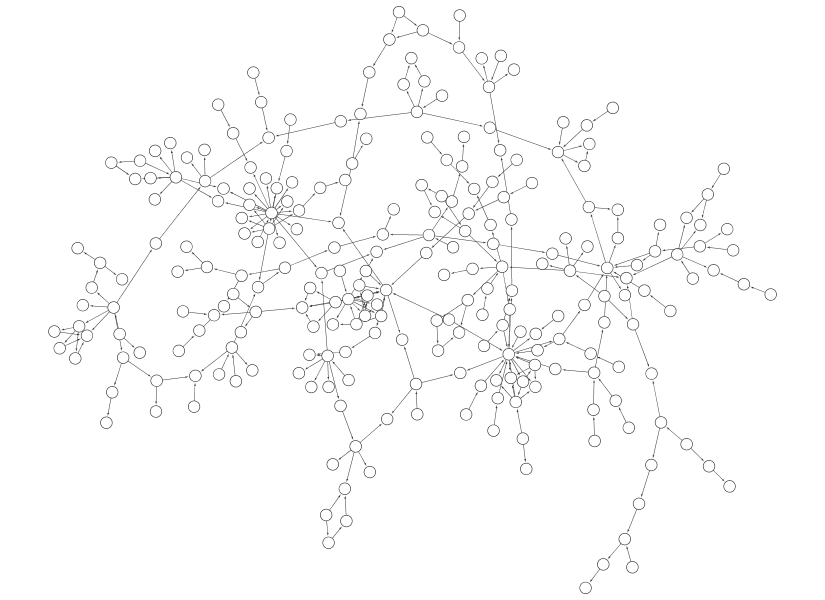

In [15]:
# Create dictionary object from JSON file
f = open('data/yeast.json', 'r')
cyjs_network = json.load(f)

# Set network name
cyjs_network['data']['name'] = 'Yeast Sample 1' 

res = requests.post(BASE + 'networks', data=json.dumps(cyjs_network), headers=HEADERS)
new_suid = res.json()['networkSUID']

# Apply style and layout
requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
requests.get(BASE + 'apply/styles/Directed/' + str(new_suid))

Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

## Data Round-Trip between Cytoscape and NetworkX
Basic data exchange format for cyREST is Cytoscape.js JSON.  To use objects in Cytoscape.js JSON format in other network libraries, we need to write a converter code for data rounndtrip. 

### py2cytoscape
This is still an ongoing project, but we are developing utility library named __py2cytoscape__ which includes data conversion utilities and other usiful functions for Python users.  Aa of today (March 2015), data roundtrip between Cytoscape,js JSOB and NetworkX is supported.

Here is the simplest example:

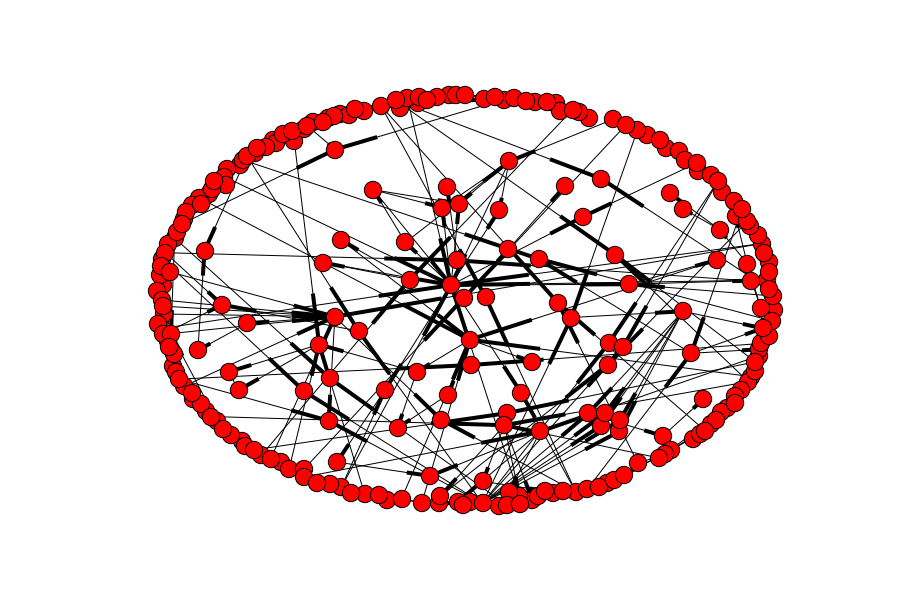

In [16]:
# Convert Python dictionary in Cytoscape.js format into NetworkX object
nx_network = cy.to_networkx(cyjs_network)

# Draw it with NetworkX renderer 
plt.figure(figsize=(12,8));
nx.draw_spring(nx_network)

Well, now you can see why we want to use Cytoscape as an external rendering engine...

### Generate graph with NetworkX

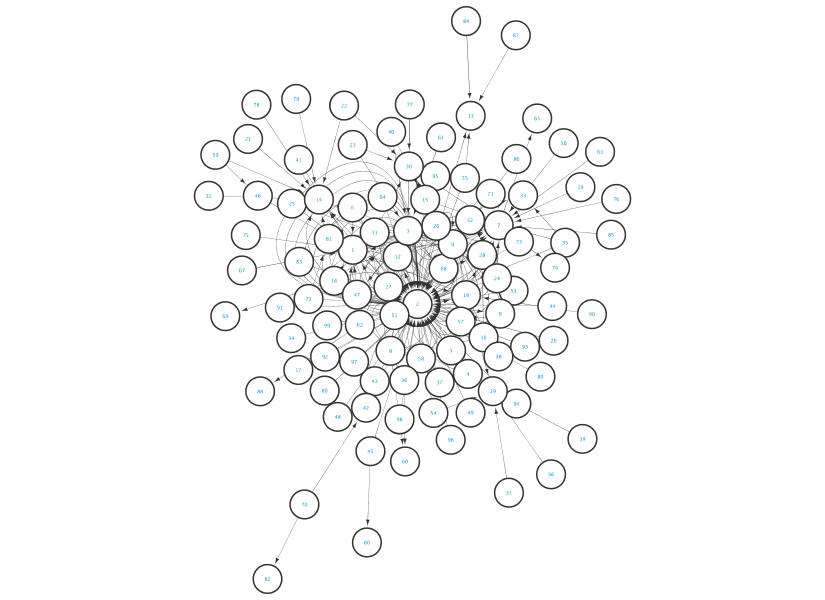

In [19]:
# Generate graphs with NetworkX

# Scale-Free graph wiht 100 nodes (Directed)
scale_free_graph = nx.scale_free_graph(100)
scale_free_graph.graph['name'] = 'Scale-Free Graph'

# Convert it into Cytoscape.js format

def post_nx(nx_graph, layout='force-directed'):
    # Convert into Cytoscape.js JSON
    cyjs_network = cy.from_networkx(nx_graph)
    # POST it!
    res = requests.post(BASE + 'networks', data=json.dumps(cyjs_network), headers=HEADERS)
    suid = res.json()['networkSUID']
    requests.get(BASE + 'apply/layouts/' + layout + '/' + str(suid))
    return Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True)

network_images = []
network_images.append(post_nx(scale_free_graph))
network_images[0]

In [20]:
# ...And other graph generators

graphs = {}
NUMBER_OF_NODES = 100

# Add Converted Cytoscape network
graphs['yeast'] = nx_network

# Complete
graphs['complete'] = nx.complete_graph(NUMBER_OF_NODES)

# Circular Ladder
graphs['circular ladder'] = nx.circular_ladder_graph(NUMBER_OF_NODES)

# Binominal
graphs['binominal'] = nx.binomial_graph(NUMBER_OF_NODES, 0.3)

for key in graphs.keys():
    g = graphs[key]
    # Perform simple graph analysis
    
    # Node statistics
    bc = nx.betweenness_centrality(g)
    degree = nx.degree(g)
    cc = nx.closeness_centrality(g)
    nx.set_node_attributes(g, 'betweenness', bc)
    nx.set_node_attributes(g, 'closeness', cc)
    nx.set_node_attributes(g, 'degree', degree)
    
    # Network statistics
    g.graph["avg_shortest_path_len"] = nx.average_shortest_path_length(g)
    g.graph["density"] = nx.density(g)
    network_images.append(post_nx(g, 'circular'))

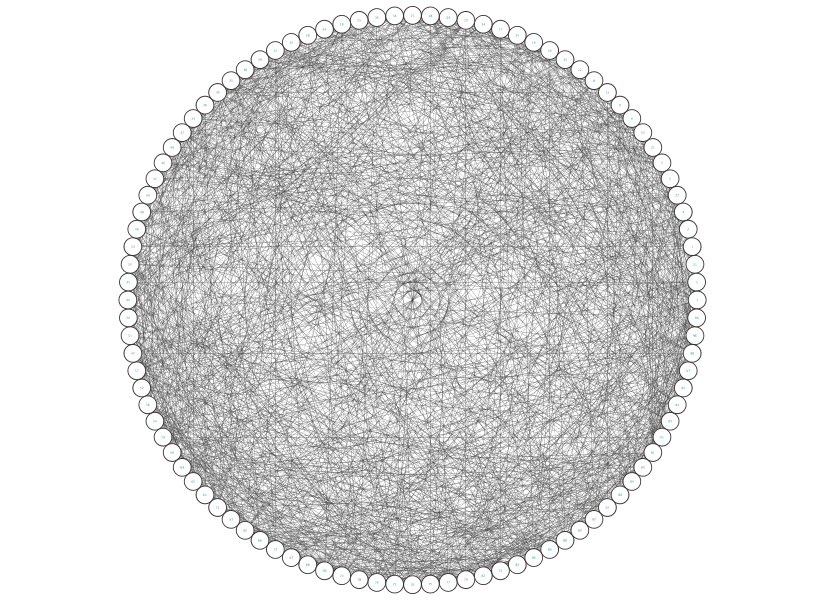

In [24]:
network_images[1]

## Load unsupported files
Cytoscape supports many standard graph file formats, including GML, GraphML, or XGMML, but there several more standad formats like DOT used in Graphviz.  You can use graph-tools and other libraries as a data converter.

### DOT to GraphML

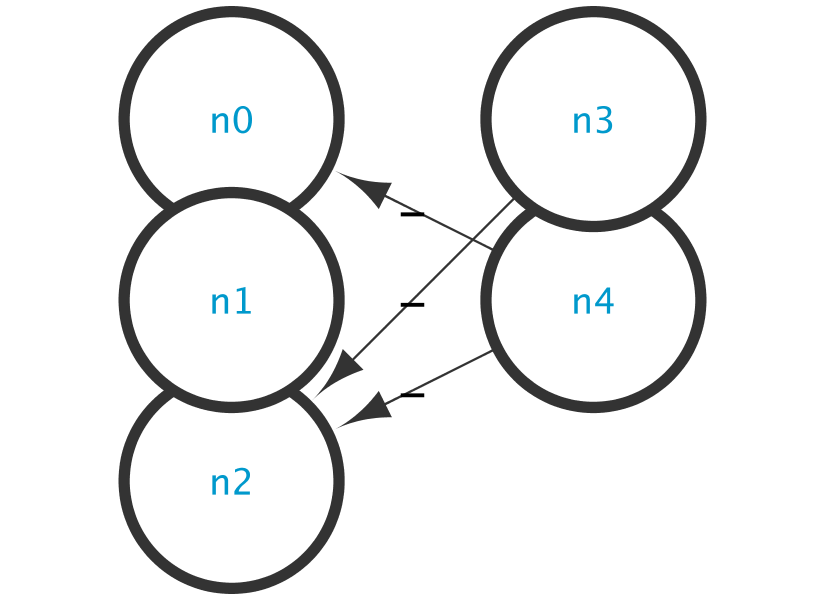

In [33]:
import graph_tool as gt
import graph_tool.collection as collection


dot_graph = gt.load_graph('data/sample.dot')
dot_graph.save('data/sample.graphml', fmt='graphml')

def create_from_list(network_list):
    payload = {'source': 'url', 'collection': 'Dot Sample'}
    server_res = requests.post(BASE + 'networks', data=json.dumps(network_list), headers=HEADERS, params=payload)
    return server_res.json()


# Array of data source. 
network_file = 'file:////Users/kono/git/vizbi-2015/tutorials/data/sample.graphml'
id_json = create_from_list([network_file])
suid = id_json[0]['networkSUID'][0]
Image(url=BASE+'networks/' + str(suid) + '/views/first.png', embed=True)

## Use igraph for network analysis

In [50]:
import igraph

gal= igraph.Graph.Read_GML('data/galFiltered.gml')
dend = gal.community_edge_betweenness()

clusters = dend.as_clustering()
gal.vs['clusters'] = clusters.membership

gal.vs['label']

df = pd.DataFrame(gal.vs['clusters'], gal.vs['label'], columns=['cluster'])
df.to_csv('data/clusters.txt')
df.head(10)

,cluster
YKR026C,0
YGL122C,0
YMR146C,1
YDR429C,1
YFL017C,1
YOL123W,2
YGL044C,2
YGR203W,1
YIL061C,1
YCR084C,1


In [ ]:
## 

In [80]:
import graph_tool.community as community
import graph_tool.draw as draw

g = gt.load_graph('data/yeast.gml')

pos = draw.arf_layout(g, max_iter=0)
# state = community.minimize_blockmodel_dl(g)
# b = state.b
draw.graph_draw(g, pos=pos, output_size=(950, 1000), inline=True)

ZeroDivisionError: division by zero

## Data mangling with Pandas

In [81]:
df1 = pd.read_csv('http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca*?format=tab27', 
                  delimiter='\t', header=None)
df1.head()

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,uniprotkb:Q9Y385,uniprotkb:P38398,intact:EBI-988826|uniprotkb:Q53F25|uniprotkb:A...,intact:EBI-349905|uniprotkb:Q1RMC1|uniprotkb:Q...,psi-mi:ub2j1_human(display_long)|uniprotkb:Non...,psi-mi:brca1_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0397""(two hybrid array)",-,imex:IM-9597|pubmed:19690564,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:nc3+V3Qxy1ZDhTWgTPLakJukxPM9606,rogid:Tx+5uS8dERqc0lhPZ0ZIKQaifXM9606,intact-crc:88DA48E32D6776A3|rigid:EBTmW/sLTONK...,False,-,-,-,-,"psi-mi:""MI:0396""(predetermined participant)","psi-mi:""MI:0396""(predetermined participant)"
1,uniprotkb:Q5VVX9,uniprotkb:Q99728,intact:EBI-2130181|uniprotkb:Q8N1D4,intact:EBI-473181|uniprotkb:F6MDH9|uniprotkb:F...,psi-mi:ube2u_human(display_long)|uniprotkb:UBE...,psi-mi:bard1_human(display_long)|uniprotkb:BAR...,"psi-mi:""MI:0397""(two hybrid array)",-,imex:IM-9597|pubmed:19690564,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:onw4DUslrZLhQZp8FtqY6s6Q/u09606,rogid:5dT1T3GUceuvwPpiTv5QW/QEDgE9606,intact-crc:35FBF5E49A9671E0|rigid:EvuHsiDjMeWq...,False,-,-,-,-,"psi-mi:""MI:0396""(predetermined participant)","psi-mi:""MI:0396""(predetermined participant)"
2,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:72C657CC1BAB693B,False,-,mutation decreasing interaction:1526-1526|glut...,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
3,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:29B545670D1E5C62,False,-,mutation decreasing interaction:1526-1526|glut...,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."
4,uniprotkb:Q06609,uniprotkb:P51587,intact:EBI-297202|intact:EBI-1059207|uniprotkb...,intact:EBI-79792|uniprotkb:Q13879|uniprotkb:O1...,psi-mi:rad51_human(display_long)|uniprotkb:RAD...,psi-mi:brca2_human(display_long)|uniprotkb:BRC...,"psi-mi:""MI:0413""(electrophoretic mobility shif...",Carreira et al. (2009),pubmed:19303847|imex:IM-20288,taxid:9606(human)|taxid:9606(Homo sapiens),...,rogid:B7WPMU7tZuNcA2qjsTR+7i/OwFw9606,rogid:UcdngwpTSS6hG/pvQGgpp40u67I9606,intact-crc:FDB2287FC7FF8835,False,-,necessary binding region:1525-1530,-,-,"psi-mi:""MI:0821""(molecular weight estimation b...","psi-mi:""MI:0821""(molecular weight estimation b..."


In [72]:
brca_df = pd.DataFrame()
brca_df['source'] = df1[0]
brca_df['target'] = df1[1]
len(brca_df)


689

In [79]:
# Small function to create NetworkX graph from DataFrame
net = nx.MultiGraph()
for i in range(len(brca_df)):
    row = brca_df.ix[i]
    net.add_node(row['source'])
    net.add_node(row['target'])
    net.add_edge(row['source'], row['target'])


print(len(net.edges()))

res = requests.post(BASE + 'networks', data=json.dumps(cy.from_networkx(net)), headers=HEADERS)

689


In [71]:
cl2 = nx.find_cliques(nx_human)
cls2 = [c for c in cl2]

In [74]:
clsize1 = [len(c) for c in cls2]
max(clsize1)

197

In [67]:
res = requests.post(BASE + 'networks?title=human-net', data=json.dumps(cyjs_human), headers=HEADERS)
new_suid = res.json()['networkSUID']

In [55]:
edge_list = df2[[0,1]]
edgelist_str = edge_list.to_csv(sep='\t', header=None, index=None)

res = requests.post(BASE + 'networks?format=edgelist&title=human-net', data=edgelist_str, headers=HEADERS)
new_suid = res.json()['networkSUID']

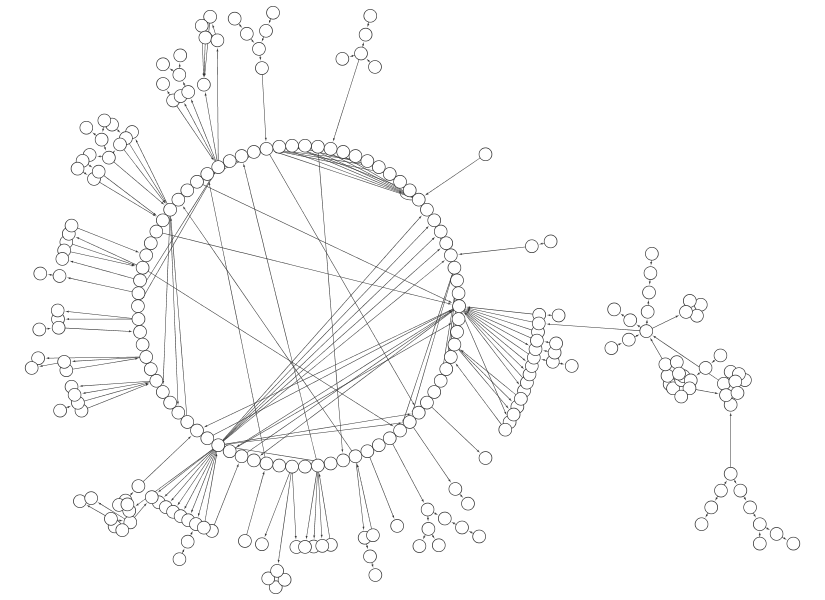

In [38]:
requests.get(BASE + 'apply/layouts/circular/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')

In [39]:
df1.head()
edge_list = df1[[0,1]]
edge_list.head()
edgelist_str = edge_list.to_csv(sep='\t', header=None, index=None)

res = requests.post(BASE + 'networks?format=edgelist', data=edgelist_str, headers=HEADERS)
new_suid = res.json()['networkSUID']

requests.get(BASE + 'apply/layouts/force-directed/' + str(new_suid))
Image(BASE+'networks/' + str(new_suid) + '/views/first.png')


NameError: name 'df1' is not defined